# Analysis of Crime Reports in Portland, OR, 2004-2014

This analysis takes a first look at an extensive dataset of crime reports in Portland, OR from 2004 to 2014. It contains over 680,000 entries, each with location information and classification about what kind of offense was reported. **N.B. The year 2010 is entirely omitted from this analysis.** The data for 2010 were not included on the Kaggle website, as they have not been published through the City of Portland's website.

*Project dataset can be found here: https://www.kaggle.com/katzwigmore/portland-oregon-crime-data/*

There are myriad stories to tell in this dataset, and the goal of this analysis will be to start to answer these three questions: 

**What are the broad trends in the crime reports from 2004 to 2014?**

**Have certain types of offenses become more or less common compared to the whole?**

**Are crime reports in specific neighborhoods noticeably different from those of the city at large?**

Let's dig in.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The data is structured into separate files by year, however it will be easier to manipulate if it's in a single dataframe. Let's import all the data and combine it in a useful format.

In [2]:
df2004 = pd.read_csv('crime_incident_data2004.csv')
df2005 = pd.read_csv('crime_incident_data2005.csv')
df2006 = pd.read_csv('crime_incident_data2006.csv')
df2007 = pd.read_csv('crime_incident_data2007.csv')
df2008 = pd.read_csv('crime_incident_data2008.csv')
df2009 = pd.read_csv('crime_incident_data2009.csv')
df2011 = pd.read_csv('crime_incident_data2011.csv')
df2012 = pd.read_csv('crime_incident_data2012.csv')
df2013 = pd.read_csv('crime_incident_data2013.csv')
df2014 = pd.read_csv('crime_incident_data2014.csv')

Adding a 'Year' column so we don't lose that information when we merge the dataframes.

In [3]:
df2004['Year'] = 2004
df2005['Year'] = 2005
df2006['Year'] = 2006
df2007['Year'] = 2007
df2008['Year'] = 2008
df2009['Year'] = 2009
df2011['Year'] = 2011
df2012['Year'] = 2012
df2013['Year'] = 2013
df2014['Year'] = 2014

In [4]:
df = pd.concat([df2004, df2005, df2006, df2007, df2008, df2009, df2011, df2012, df2013, df2014])
all_years = [2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014]

# General Overview

This is a large dataset with a lot going on. Let's start by looking at some of the basics. 

In [5]:
len(df)

680075

There are 680,000 crime reports over the ten years of data. That is 68,000 reports per year, or more than 180 per day. The police department is busy!

Here's a look at how the data is formatted.

In [6]:
df.iloc[[1]]

,Record ID,Report Date,Report Time,Major Offense Type,Address,Neighborhood,Police Precinct,Police District,X Coordinate,Y Coordinate,Year
1,10704487,02/11/2004,09:18:00,Motor Vehicle Theft,"NE WEIDLER ST and NE 1ST AVE, PORTLAND, OR 97232",LLOYD,PORTLAND PREC NO,690,7.647471e+06,688344.45,2004


Luckily the dataset is already quite clean -- each row is an individual crime report, and includes the date, the time, the type of offense, street address, neighborhood, X and Y coordinates, and year (which we added). The other columns are not used in this analysis. Still, there is plenty to do here. 

The bar plot below shows the total number of crime reports per year for all of Portland. 

**Note: From here forward I will use "crime reports" and "crimes" interchangeably, but it is important to keep in mind that we are always looking at the reports themselves. This does not include unreported crimes, and does not imply that parties involved were found to be guilty of the reported crime.**

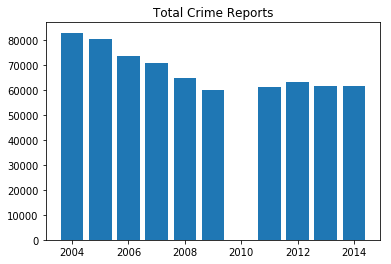

In [7]:
plt.bar(all_years, [len(df[df['Year']==x]) for x in all_years])

plt.title('Total Crime Reports')
plt.show()

We see a general trend downward from 2004 to 2009, then a leveling-off up to 2014. We'll look at that in more detail later on.

Before we start to get into the nitty gritty of what kinds of crimes happened where, let's look at some more dataset-wide variables: time and date.

### What time of day are crimes reported?

In [8]:
def get_time(time):
    [h, m, s] = time.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def give_time(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return "%02d:%02d:%02d" % (h, m, s)

A histogram of all the data points should work nicely for our purposes. My function "get_time(x)" returns a value in seconds, so I've divided by 3600 to convert to military time.

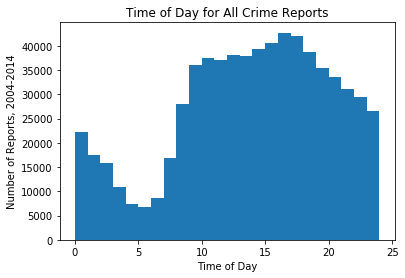

In [9]:
plt.hist([get_time(x)/3600 for x in df['Report Time']], bins=24)
plt.xlabel('Time of Day')
plt.ylabel('Number of Reports, 2004-2014')

plt.title('Time of Day for All Crime Reports')
plt.show()

Not much surprising here: Crime reports are lowest around 4-5 AM, and peak in the late afternoon around 5 PM. It may be that more crimes are committed during the day, however, the dataset doesn't give insight into whether crime reports are closely correlated to the time the crime is actually committed. If somebody breaks into your house or car during the day, you aren't likely to report the crime until you get home from work.

### Is there a seasonal shift in crime?

It would be interesting to see if there's a seasonal trend in crime reports. Let's take a look at the data over the full time series.

In [10]:
def get_date(date):
    [m, d, y] = date.split('/')
    return int(y) + (int(m)-1)/12 + (int(d)-1)/365

def get_month(date):
    [m, d, y] = date.split('/')
    return int(m)

Again, a simple histogram should allow us to see in which months the most crimes occur.

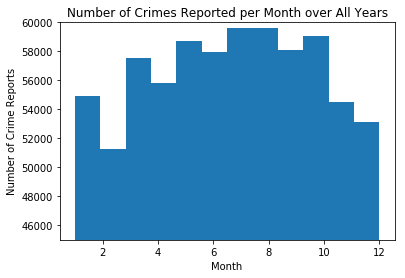

In [11]:
plt.hist([get_month(x) for x in df['Report Date']], bins=12)
plt.xlabel('Month')
plt.ylabel('Number of Crime Reports')
plt.ylim(45000, 60000)

plt.title('Number of Crimes Reported per Month over All Years')
plt.show()

It looks like the variation in crime is due to the number of days in a month more than anything else. To correct for this, let's instead look at the daily average of crime reports for each month over all of the data. Rather than try incorporate this correction into the whole dataframe, I'll create a list with the number of crimes occurring in each month.

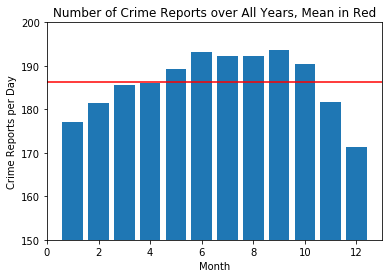

In [12]:
month_weights = [1/31, 1/28.25, 1/31, 1/30, 1/31, 1/30, 1/31, 1/31, 1/30, 1/31, 1/30, 1/31]

crimes_by_month = []
for i in range(12):
    crimes_by_month.append([get_month(x) for x in df['Report Date']].count(i+1)*month_weights[i]/10)
    
plt.figure(figsize=(6, 4))
plt.bar(range(1,13), crimes_by_month)
plt.axhline(np.mean(crimes_by_month), color='red')
plt.xlabel('Month')
plt.ylabel('Crime Reports per Day')
plt.ylim([150, 200])

plt.title('Number of Crime Reports over All Years, Mean in Red')
plt.show()

After correcting for the number of days in each month, there is a clear trend of increased crime in the summer, peaking from May to October. This corresponds nicely with the "good weather" in Portland. May through October is generally sunny and beautiful, while December through March is rainy and cold. The daylight in the summer is also about five hours longer than in the winter. These factors likely contribute to an increase of crime during the summer months.

# Crime Report Locations

Where did these crimes take place? Because the data provides X and Y coordinates, we have an easy way of visualizing the data without having to worry about geolocating street addresses. Because of the density of crime reports, we'll actually be able to get a pretty good map of the city just by plotting each report in X-Y space.

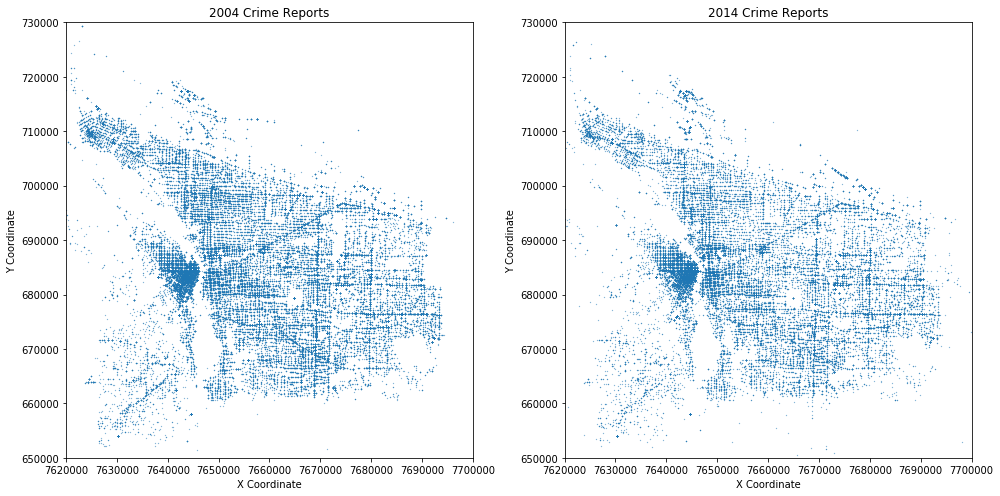

In [13]:
plt.figure(figsize=(14,7))
years = [2004, 2014]

for i in range(len(years)):

    plt.subplot(1,2,i+1)
    plt.scatter(
        df[df['Year']==years[i]]['X Coordinate'], 
        df[df['Year']==years[i]]['Y Coordinate'], 
        s = .05
        )
    plt.xlim(7620000, 7700000)
    plt.ylim(650000, 730000)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('{} Crime Reports'.format(years[i]))

plt.tight_layout()
plt.show()

We can see how the density of crime changes throughout the city -- the dense cluster of points around (7640000, 680000) is Downtown Portland. The blank swath through the middle is the river, and the strong diagonal line running northeast from the city center is Sandy Blvd, which is a main thoroughfare. Those familiar with the city will recognize other busy streets and neighborhood centers.

### Where do specific types of crime occur?

We'll look more into specific types of crime later on, but it would be interesting to see where certain crimes occur in the city. For the most part, the dataset is too large to use an overlay technique like the one below to visualize specific crimes (something like a heat map would work better, as it would show density rather than individual locations -- that would be a great future project). Some of the rarest crimes, however, are also the ones we're most interested in. If we look at homicides in the city, we can plot all of them without washing out the interesting parts of the data. 

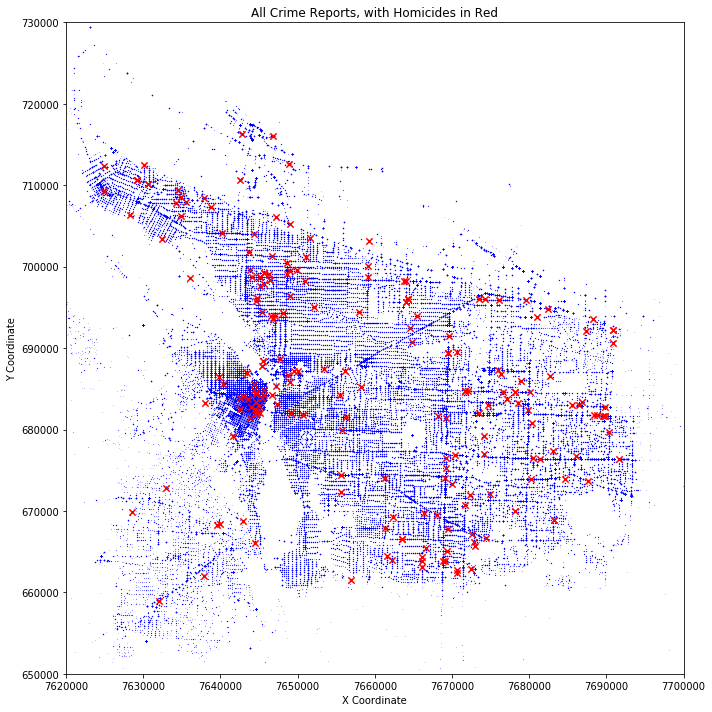

In [14]:
plt.figure(figsize=(10,10))

crime_type = 'Homicide' # Enter crime type

# To look at a one specific year
'''
year = 2009 # Enter desired year

plt.scatter(
    df[df['Year']==year]['X Coordinate'], 
    df[df['Year']==year]['Y Coordinate'], 
    s=.05, 
    c='b')
plt.scatter(
    df[(df['Year']==year) & (df['Major Offense Type']==crime_type)]['X Coordinate'], 
    df[(df['Year']==year) & (df['Major Offense Type']==crime_type)]['Y Coordinate'], 
    s=60, 
    c='r',
    marker='x'
    )
'''

# Or, visualize all years.
year = 'All'
plt.scatter(
    df['X Coordinate'], 
    df['Y Coordinate'], 
    s=.005, 
    c='b')
plt.scatter(
    df[(df['Major Offense Type']==crime_type)]['X Coordinate'], 
    df[(df['Major Offense Type']==crime_type)]['Y Coordinate'], 
    s=40, 
    c='r',
    marker='x'
    )


plt.xlim(7620000, 7700000)
plt.ylim(650000, 730000)
plt.title('{} Crime Reports, with {}s in Red'.format(year, crime_type))
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

This plot tells us a lot. Homicides occur most often Downtown and around the outer neighborhoods of the city. There is specifically a concentration of homicides in the area north of Downtown, and farther out to the east, which corresponds roughly to the economic status of these neighborhoods. The ring around downtown with no homicides is composed of the wealthier, "nicer" neighborhoods. A deep analysis of those relationships, although warranted, is beyond the scope of this project.

There is a lot more to do with this location data, but at this point it would probably make the most sense to pull it into ArcGIS and do the analysis on a platform specifically designed for it.

## Types of Crime Reports

What types of crime are reported in Portland? Let's take a look.

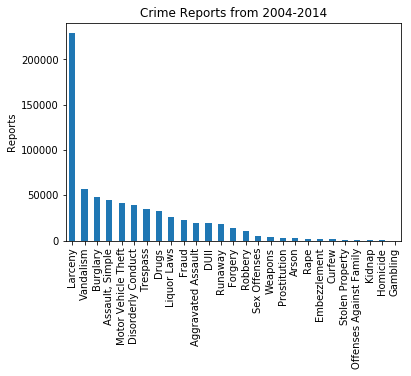

In [15]:
df['Major Offense Type'].value_counts().plot(kind='bar')

plt.title('Crime Reports from 2004-2014')
plt.ylabel('Reports')
plt.show()

Larceny (theft) dominates the dataset. Let's see how things look without it.

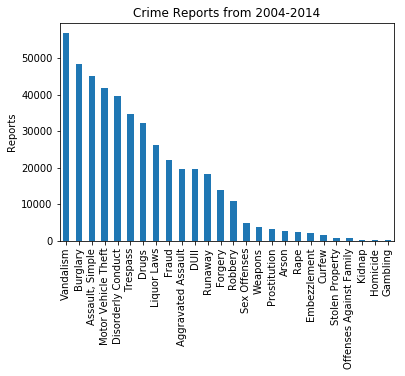

count       26.000000
mean     17360.576923
std      17879.352273
min         27.000000
25%       2125.750000
50%      12287.000000
75%      30823.000000
max      56811.000000
Name: Major Offense Type, dtype: float64

In [16]:
df['Major Offense Type'].value_counts()[1:].plot(kind='bar')

plt.title('Crime Reports from 2004-2014')
plt.ylabel('Reports')
plt.show()
df['Major Offense Type'].value_counts()[1:].describe()

Excluding Larceny, there are several types of crime which are quite common, and a tail of rare crimes. Crime reports are broken up into 27 types of crime. The upper 25% have 30,000+ reports over ten years, while the lower 25% have fewer than 2,200 -- the tail. Some of the crimes which are most concerning are there (Sex Offenses, Rape, Homicide), so let's take a closer look at the tail.

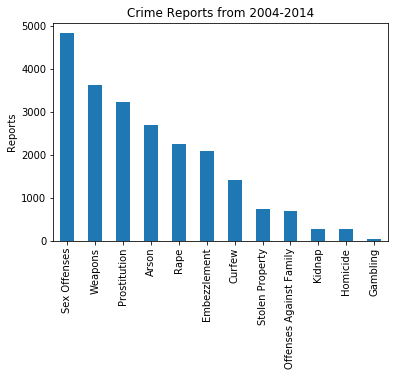

In [17]:
df['Major Offense Type'].value_counts()[-12:].plot(kind='bar')

plt.title('Crime Reports from 2004-2014')
plt.ylabel('Reports')
plt.show()

Let's take a look at homicides from year to year to see how that has changed over time. We'll look at this more in depth later on.

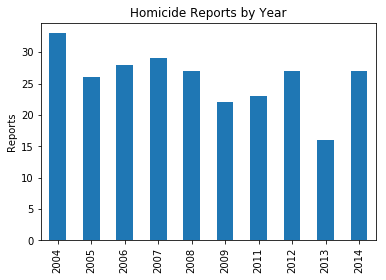

In [18]:
df[df['Major Offense Type']=='Homicide']['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Homicide Reports by Year')
plt.ylabel('Reports')
plt.show()

Thankfully, there appears to be a general trend downward in homicides. This agrees with the prevailing feeling in the city that things have become safer (and more affluent) over the past 10+ years. 


### Trends over time of specific crime types

We've gotten the general sense that crime has decreased from 2004 to 2014, but let's look at this a bit more concretely. Specifically, let's compare the first three years of data (2004-2006) with the last three (2012-2014). By spanning a few years on either side we may smooth out anomalous years.

In [19]:
all_crimes = sorted(list(df['Major Offense Type'].unique()))

crime_counts = pd.DataFrame()

for year in all_years:
    for crime in all_crimes:
        crime_counts.loc[crime, year] = len(df[(df['Year']==year) & (df['Major Offense Type']==crime)])
        
crime_sorted = crime_counts.sort_values(2005, ascending=False) # Sorting by the frequency of crimes in 2005

Rather than get bogged down taking 'value_counts()' of every possible variable, I decided to create a second dataframe with the number of each crime reported in each year. I chose to sort the whole dataframe by the '2005' column because it was most similar to the values in (2004+2005+2006). This was a workaround to allow me to compare different time segments without having to resort multiple times.

In [20]:
crime_sorted

,2004,2005,2006,2007,2008,2009,2011,2012,2013,2014
Larceny,28255.0,25614.0,21797.0,22022.0,21061.0,19515.0,22048.0,22281.0,21929.0,24178.0
Vandalism,6097.0,6356.0,7024.0,6960.0,5783.0,5113.0,4910.0,4933.0,5224.0,4411.0
Burglary,7255.0,6041.0,5459.0,4902.0,4202.0,3713.0,4255.0,4535.0,4029.0,4102.0
Motor Vehicle Theft,6050.0,5802.0,4583.0,4905.0,3408.0,3284.0,3283.0,3642.0,3363.0,3449.0
"Assault, Simple",4952.0,5117.0,5119.0,4935.0,4525.0,4285.0,4005.0,4144.0,4017.0,3935.0
Trespass,5151.0,5058.0,3972.0,3324.0,3098.0,2785.0,2715.0,3016.0,2812.0,2805.0
Drugs,3601.0,4566.0,4200.0,3445.0,2825.0,2370.0,2559.0,2892.0,3257.0,2668.0
Disorderly Conduct,3941.0,3988.0,4034.0,3809.0,3836.0,4035.0,3975.0,3895.0,4046.0,4008.0
Fraud,2896.0,2920.0,2741.0,2518.0,2211.0,1930.0,1602.0,1697.0,1663.0,2008.0
Aggravated Assault,2292.0,2327.0,2198.0,2069.0,1966.0,1776.0,1763.0,1847.0,1737.0,1699.0


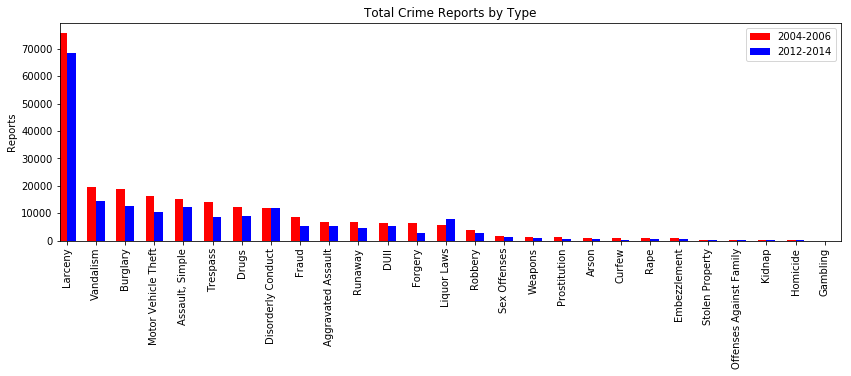

In [21]:
fig, ax = plt.subplots(figsize=(14,4))
width = .3

(crime_sorted[2004]+crime_sorted[2005]+crime_sorted[2006]).plot(
    kind='bar',
    position=1,
    color='red',
    width=width,
    label='2004-2006'
    )

(crime_sorted[2012]+crime_sorted[2013]+crime_sorted[2014]).plot(
    kind='bar',
    position=0,
    color='blue',
    width=width,
    label='2012-2014'
    )

plt.legend()
plt.ylabel('Reports')
plt.title('Total Crime Reports by Type')
plt.show()

It's clear that there are generally more crimes in 2004-2006 than in 2012-2014, but again it's hard to see the scale because of how prevalent Larceny is. Let's look at the same data with Larceny removed.

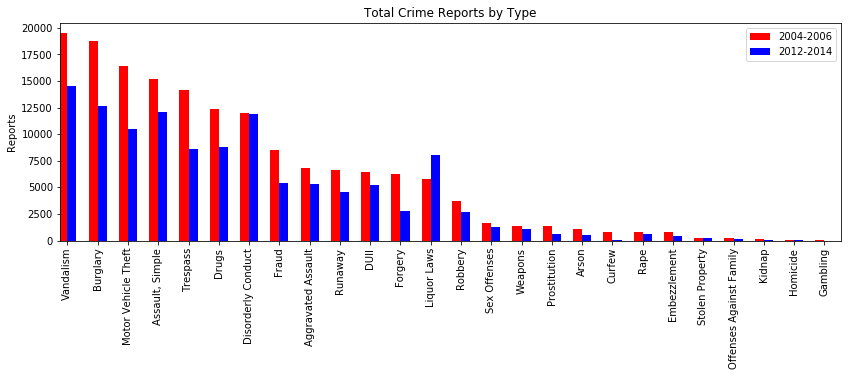

In [22]:
fig, ax = plt.subplots(figsize=(14,4))
width = .3

(crime_sorted[2004]+crime_sorted[2005]+crime_sorted[2006])[1:].plot(
    kind='bar',
    position=1,
    color='red',
    width=width,
    label='2004-2006'
    )

(crime_sorted[2012]+crime_sorted[2013]+crime_sorted[2014])[1:].plot(
    kind='bar',
    position=0,
    color='blue',
    width=width,
    label='2012-2014'
    )

plt.legend()
plt.ylabel('Reports')
plt.title('Total Crime Reports by Type')
plt.show()

Most crimes show a decrease, however Disorderly Conduct and Liquor Laws do not. This could be a result of increased enforcement, increased reporting, or some change in the city that has led to an increase in frequency of those crimes. It does seem that these two crimes could be correlated, and may even get reported simultaneously. This would be a good place for deeper future analysis.

And as before, let's look at just the tail of less common crimes.

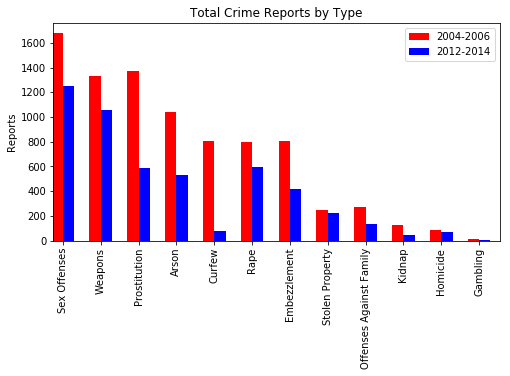

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
width = .3

(crime_sorted[2004]+crime_sorted[2005]+crime_sorted[2006])[-12:].plot(
    kind='bar',
    position=1,
    color='red',
    width=width,
    label='2004-2006'
    )

(crime_sorted[2012]+crime_sorted[2013]+crime_sorted[2014])[-12:].plot(
    kind='bar',
    position=0,
    color='blue',
    width=width,
    label='2012-2014'
    )

plt.legend()
plt.ylabel('Reports')
plt.title('Total Crime Reports by Type')
plt.show()

Prostitution, Curfew, Embezzlement, and Kidnap have seen dramatic declines between the beginning and end of the dataset. A deeper analysis of these types of crime reports would be interesting and require a more thorough understanding of how these crimes are reported in Portland.

### How have rates of specific offense types evolved over the full length of the data?

What if we look at a specific crime over the full time series like we did previously with Homicide? So far we've identified a few crime types as being potentially interesting. In order to compare one type to another, we'll have to normalize the data so they are on the same scale. I've done this simply by dividing the number of crimes in a specific year by the total number of that crime reported over the time series.

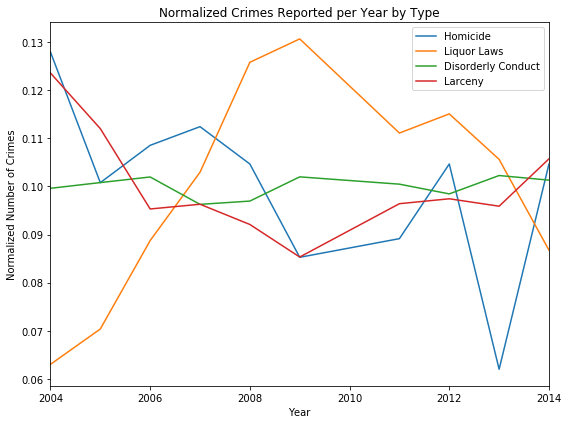

In [24]:
fig = plt.figure(figsize=(8,6))

# Choose which crimes to look at.

#select_crimes = all_crimes[:5] 
select_crimes = ['Homicide', 'Liquor Laws', 'Disorderly Conduct', 'Larceny']

for crime in select_crimes:
    (crime_sorted.loc[crime]/crime_sorted.loc[crime].sum()).plot(kind='line', label=crime)

    
plt.ylabel('Normalized Number of Crimes')
plt.xlabel('Year')
plt.legend()
plt.title('Normalized Crimes Reported per Year by Type')
plt.tight_layout()
plt.show()

It turns out Liquor Law reports have a different story than we would have expected from the cursory analysis above. They started at low levels in 2004, peaked in 2009, and were actually decreasing again by 2014. Disorderly Conduct remains flat, while Larceny actually bottoms out in 2009 and appears to be on the rise. Homicides are infrequent enough that the data are noisy and jump around a lot. This is an important lesson that is it easy to mislead with statistics. One could truthfully say, *"Liquor Law crime reports have increased by 50% over the last ten years"* and *"Liquor Law crime reports have decreased by 40% over the last five years."* 

# Crime Reports by Neighborhood

Let's take a look at how crime reports change based on neighborhood. First, a quick glance at what the neighborhood structure looks like.

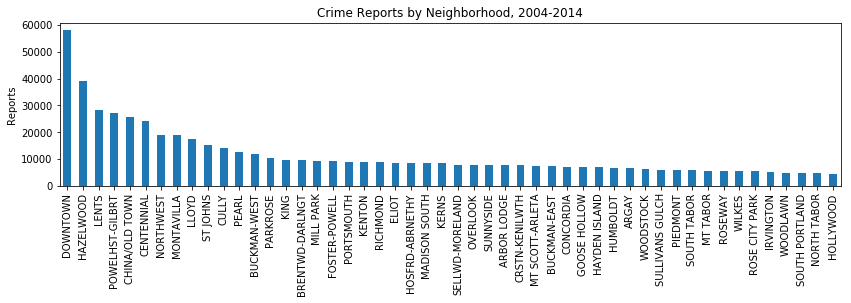

count      137.000000
mean      4897.291971
std       7860.670157
min          1.000000
25%         43.000000
50%       2369.000000
75%       6842.000000
max      57901.000000
Name: Neighborhood, dtype: float64

In [25]:
### Here's a list of some of the neighborhoods to look at for the next section.
fig = plt.figure(figsize=(14,3))

df['Neighborhood'].value_counts().head(50).plot(kind = 'bar')
#plt.axhline(df['Neighborhood'].value_counts().mean(), color='red', linewidth=1)
plt.ylabel('Reports')
plt.title('Crime Reports by Neighborhood, 2004-2014')
plt.show()
df['Neighborhood'].value_counts().describe()

There are 137 neighborhoods listed in the dataframe. Downtown has the most crime reports, with 57,901 over all years. Some Portland neighborhoods are quite small, or are far out in the suburbs, and have as low as a single crime reported over the time series. Most of the commonly known neighborhoods in the city occur in the top 50, with fewer than 10,000 reports over ten years.

If we plot a histogram of the distribution of neighborhoods with certain levels of crime, we see that the distribution is not normal -- in fact it is much closer to geometric. There are many small, low-crime neighborhoods, and only a few high-crime neighborhoods.

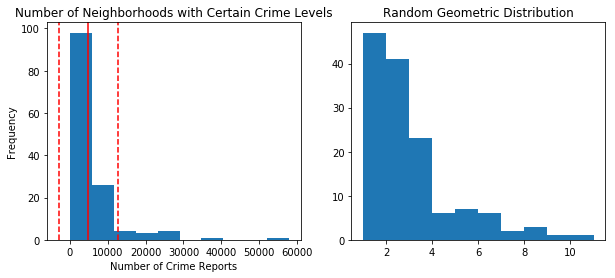

In [26]:
#Plot reports by neighborhood vs a normal distribution

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
neighborhood_dist = df['Neighborhood'].value_counts()

neighborhood_dist.plot(kind = 'hist')
plt.axvline(neighborhood_dist.mean(), color='red')
plt.axvline(neighborhood_dist.mean() + neighborhood_dist.std(), linestyle='dashed', color='red')
plt.axvline(neighborhood_dist.mean() - neighborhood_dist.std(), linestyle='dashed', color='red')

plt.title('Number of Neighborhoods with Certain Crime Levels')
plt.xlabel('Number of Crime Reports')

plt.subplot(1,2,2)

geometric_dist = np.random.geometric(.4, 137)

plt.hist(geometric_dist)

plt.title('Random Geometric Distribution')
plt.show()



### Has Crime Trended Differently Over Time By Neighborhood?

What if we compare the change in crime reports in a single neighborhood to the city as a whole? This is a common statistic you might see on a real estate website. 

In [1]:
neighborhood = 'Sabin'.upper() # Enter the Neighborhood you'd like to see. Try "Hazelwood" and "Sabin".

fig, ax1 = plt.subplots(figsize=(7,5))

ax2 = ax1.twinx()
ax1.plot(df.Year.value_counts().sort_index(), 'b-')
ax2.plot(df[df['Neighborhood']==neighborhood]['Year'].value_counts().sort_index(), 'g-')

ax1.set_xlabel('Year')
ax1.set_ylabel('All Portland', color='b')
ax1.set_ylim([0, 1.1*df.Year.value_counts().sort_index().max()])
ax2.set_ylabel('{} Neighborhood'.format(neighborhood.capitalize()), color='g')
ax2.set_ylim([0, 1.1*df[df['Neighborhood']==neighborhood]['Year'].value_counts().sort_index().max()])

plt.title('Crime Reports in {} vs All Portland'.format(neighborhood.capitalize()))
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

The Sabin Neighborhood, where the author lives (and which is in that "safer" ring around Downtown), has seen crime decrease faster than the city as a whole. This may be a signal that it has been gentrifying quickly (it has been). If you enter 'Hazelwood' above, you'll see the opposite -- crime reports have decreased less than the city as a whole (although they do still decrease). Hazelwood has become significantly more dense (single family homes being replaced by apartments), so it may be that the population increase has caused crime to drop more slowly than in other neighborhoods.

### Is the composition of offense types in a specific neighborhood different than the city as a whole?

Finally, let's take a look a single neighborhood (Downtown proved to be the most interesting) and see how the types of crime reports compare to those of the city at large. We'll limit our view to the nine most common crime reports, plus a tenth bin for "other."

In [28]:
neighborhood = 'Downtown'.upper() 

### First, lets make a series of the top 9 types of crime in the city as a whole, 
### plus a tenth category as a catch-all for all the rest.

offense_counts = df['Major Offense Type'].value_counts()
other = int(offense_counts[9:].sum())
offense_counts = offense_counts[:9]
top_offenses = list(offense_counts.index)
offense_counts.loc[10] = other
offense_counts = offense_counts.rename(index={10: 'Other'})

### And now, we'll find the values in the specified neighborhood of
### those same ten bins of crimes. 

### N.B. This is NOT necessarily the top 9 types of crimes in the specific 
### neighborhood, because we want to compare apples to apples.

neighborhood_counts = df[(df['Neighborhood']==neighborhood) & 
                        (df['Major Offense Type'].isin(list(offense_counts.index)))]['Major Offense Type'].value_counts()
neighborhood_other = int(df[(df['Neighborhood']==neighborhood) & 
                        ~(df['Major Offense Type'].isin(list(offense_counts.index)))]['Major Offense Type'].value_counts().sum())

neighborhood_counts.loc[10] = neighborhood_other
neighborhood_counts = neighborhood_counts.rename(index={10: 'Other'})


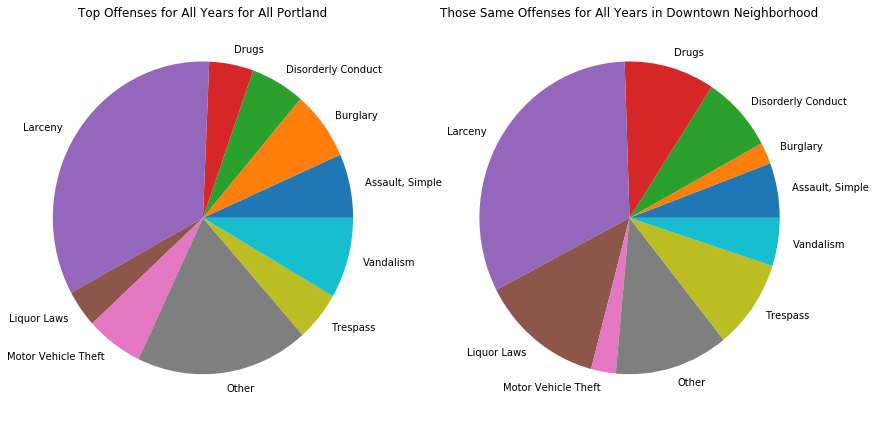

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
offense_counts.sort_index().plot.pie(
    title='Top Offenses for All Years for All Portland'
    )
plt.ylabel('')

plt.subplot(1,2,2)
neighborhood_counts.sort_index().plot.pie(
    
    title='Those Same Offenses for All Years in {} Neighborhood'.format(neighborhood.capitalize())
    )

plt.ylabel('')
plt.tight_layout()
plt.show()

How does the distribution of offense types in the Downtown neighborhood compare to the city at large? Several types of crime are MORE common in Downtown: Drugs, Disorderly Conduct, Trespass, and Liquor Laws. The City of Portland has most of its services for the homeless population in the Downtown neighborhood, and these types of non-violent crimes are the ones anecdotally associated with homelessness. It may also be that they occur together, or that downtown businesses are more likely to report these types of offenses. Further investigation would be necessary to determine if the skew toward these types of crime was connected with the concentration of the homeless population.

Note: Most neighborhoods did NOT show such a large difference in offense types from the city as a whole. Downtown is a notable anomaly.

# Conclusions and Further Research

This dataset has a huge amount going on. To address our original questions:

**What are the broad trends in the crime reports from 2004 to 2014?**
There are a few broad trends. Crime reports *have* decreased from 2004 to 2014, but not in a simple linear pattern,  and not in every offense type. There is certainly a trend of crimes being reported more in the afternoon than the early morning, but not enough information to know how that correlates to when the crimes were actually committed. There is a seasonal trend of increased crime during the summer months. The city center and the outer neighborhoods see more homicides than in inner residential neighborhoods.

**Have certain types of offenses become more or less common compared to the whole?**
Almost all types of crime reports have become less common. Two notable exceptions are Liquor Laws and Disorderly Conduct. Several offense types have seen a dramatic decrease, including Prostitution and Kidnap.

**Are crime reports in specific neighborhoods noticeably different from those in the city at large?**
The general trends of crime reports in the city do hold true for most neighborhoods, however, there is variation from neighborhood to neighborhood. Some neighborhoods have seen crime decrease faster (Sabin) or slower (Hazelwood) than the city at large, and some neighborhoods (Downtown in particular) have a substantially different distribution in the types of crime that are reported. 


Most of this analysis was simply getting a handle on what the data look like, and what kind of general trends might be occurring. There are whole columns of data we didn't touch, including Police Precinct. It would be interesting to see if certain precincts are more likely to receive reports for specific types of crimes. I would like to see what happens when we group together similar types of crime, however this would require a deeper understanding of what the Major Offense Type labels mean.

We could also draw in a wealth of other data to enrich the analysis. Something as simple as Property Taxes by neighborhood would allow us to look at a correlation between crime reports in the relatively 'safer' neighborhoods and a concrete monetary value. 

All of the location data should likely be processed in ArcGIS or similar, where we could make all sorts of informative maps and visuals. It would be interesting to highlight specific neighborhoods on the map. Portland has numerous smaller commercial hubs besides Downtown, and it would be easier to look at that with mapping software.

Thanks for reading!